In [114]:
import re
import random
import pandas as pd
import hashlib

In [115]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

# if cards_to_age['age'].mean() > 80: age_factor = .5
# else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.5) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]
if cards_to_age['age'].mean() > 80: 
    cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1.3) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.075

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())
cards_to_age['head_count'] = cards_to_age.groupby('head')['head'].transform("count")


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [116]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'mean'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
PP365 Guest Users,4.493710,4.493710,4.493710,1
Django,686.255628,17.156391,31.645886,40
Node.js and Vite,743.083813,18.123995,30.463071,41
OAuth 2.0 RFC6749,234.677066,29.334633,57.157938,8
Azure Files Documentation,1815.376331,30.256272,112.927018,60
Azure Functions + PP365,75.839495,37.919747,46.352132,2
Active Directory and Azure Files,1434.966518,38.782879,78.859992,37
CCH Tax Forms Project,841.364345,40.064969,105.354281,21
Python + Oauth2.0,1124.251086,48.880482,119.435692,23
Accounting,838.234989,49.307941,114.076935,17


# Histogram

sum of ages: ~49425.97


<Axes: >

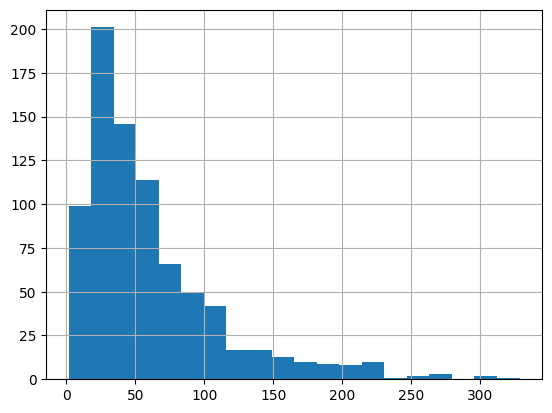

In [117]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~49425.97


<Axes: >

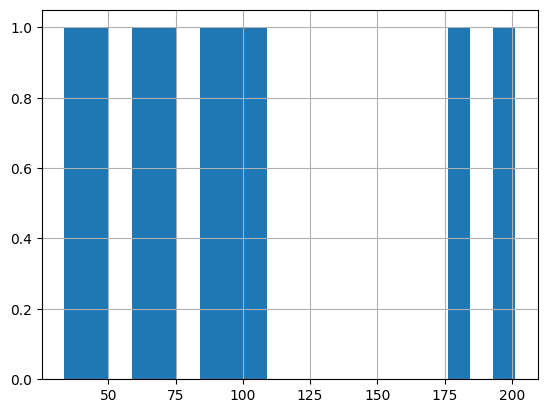

In [118]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='VMWare']['age'].hist(bins=20)

# Completely Random Shuffle

In [119]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [120]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# N-fold shuffle


## Age Sum

In [121]:
# n = 3
# m=existing_cards.shape[0]//100
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [122]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [123]:
# n = 5
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# # existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [124]:
n=5
# existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] // n

if existing_cards['age'].sum() > 0:
    # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
    existing_cards['neg_age'] = existing_cards['age'] *-1
    # existing_cards['subject_highest_age'] *= -1
existing_cards.sort_values(['n_fold', 'head_count', 'subject_highest_age', 'neg_age'], inplace=True)
remake_card_document(existing_cards=existing_cards)

existing_cards.head(10)

Cards found: 810
Total card age: 49425.97


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold,neg_age
0,PP365 Guest Users,Remember to check user (not just guest user) p...,b5ddd94780d9fc490a8cb03828646e63,4.493710,4.493710,4.493710,4.493710,0.067309,1,0,0,-4.493710
1,Azure Functions + PP365,Local Debugging\nRunning and testing Azure Fun...,cef2a4ff8162c1613bdadb864f34ed66,46.352132,37.919747,46.352132,75.839495,0.269309,2,0,0,-46.352132
2,Azure Functions + PP365,Dependency Management\nThe practice of managin...,286186c4c8443bf0b572558220e97e71,29.487363,37.919747,46.352132,75.839495,0.269309,2,1,0,-29.487363
8,OAuth 2.0 RFC6749,Instead of using the resource owner's credenti...,dc6c6e9573d09d468d57fad914fae9bf,57.157938,29.334633,57.157938,234.677066,0.023039,8,0,0,-57.157938
9,OAuth 2.0 RFC6749,OAuth defines four roles:\n\n resource owner...,239bff08336e8b3c98511be7ed1e2424,44.215071,29.334633,57.157938,234.677066,0.023039,8,1,0,-44.215071
10,OAuth 2.0 RFC6749,"The OAuth 1.0 protocol ([RFC5849]), published ...",fa67f0cf02fa18b30d2c01d93c211f6c,31.667768,29.334633,57.157938,234.677066,0.023039,8,2,0,-31.667768
11,OAuth 2.0 RFC6749,OAuth defines four roles:\n\n resource owner...,7d23d9a76d36e270739ae36e99f0fc84,30.515872,29.334633,57.157938,234.677066,0.023039,8,3,0,-30.515872
12,OAuth 2.0 RFC6749,"For example, an end-user (resource owner) can ...",0d117fe985e282b6d6989e4d7ba0a370,23.224175,29.334633,57.157938,234.677066,0.023039,8,4,0,-23.224175
3,FSLogix,Cloud Cache uses the locally mounted container...,395fe6c9edfadeac3e8be549b66ded66,177.269091,81.528983,177.269091,652.231867,0.274222,8,0,0,-177.269091
4,FSLogix,Q: Where are FSLogix Profile Containers typica...,274c33913ce1a210852da624e5f74c41,167.034791,81.528983,177.269091,652.231867,0.274222,8,1,0,-167.034791



## Random

In [125]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [126]:
existing_cards.head(10)['age'].sum()

np.float64(611.4179103620996)

In [127]:
asc = existing_cards.age.sum() < 0

existing_cards.sort_values('age', ascending=asc).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold,neg_age
53,TSQL,Stored Procedures:\n\nPrecompiled TSQL routine...,1c1c29f98d6c0bd8774d3c31bfcdd3e4,328.305512,75.711376,328.305512,1817.073016,0.031212,24,0,0,-328.305512
103,Terraform Codebox,Process segmentation fault (Segmentation fault...,e4cf055569f377aaeff23124919e4d27,306.600488,74.268061,306.600488,3639.135010,0.342064,49,0,0,-306.600488
78,PnP PowerShell,PSCredential (Microsoft.PowerShell.Security)\n...,58979b94f2077e07481d767d7e748fc9,298.939514,83.758994,298.939514,3015.323796,0.546719,36,0,0,-298.939514
63,Azure Compute Gallery,Compute Gallery Resource – The top-level conta...,cd4e5ebc6131cac516f3b36cdc1af298,272.005436,96.710641,272.005436,2707.897939,0.234119,28,0,0,-272.005436
123,Python,Q:\nHow can you measure the performance of a g...,13eda1c228af6c0fae5fc403983fa80e,267.505136,63.554180,267.505136,4512.346799,0.672465,71,0,0,-267.505136
68,Power BI,"Q: In a Pro workspace, which Service-side feat...",25b487580bae6b89adcd0c6909e8aa20,264.969563,67.954130,264.969563,2242.486285,0.700294,33,0,0,-264.969563
64,Azure Compute Gallery,One Compute Gallery Per Subscription – ACG is ...,7b7b4f84c6bc6891a0e1e7cf19f2922e,258.979334,96.710641,272.005436,2707.897939,0.234119,28,1,0,-258.979334
118,JavaScript Concepts,"A LIFO (Last-In, First-Out) stack is a way of ...",177fe59b3fb370453b5cd806c1c92ef3,246.864666,75.287093,246.864666,4667.799776,0.475834,62,0,0,-246.864666
119,JavaScript Concepts,Reserved Words: Identifiers cannot be the same...,042a95e59a28c2e0d94382aacc1a1751,231.958058,75.287093,246.864666,4667.799776,0.475834,62,1,0,-231.958058
108,CCH Axcess,Client IDs can have up to 15 characters and ca...,220856831fa9fb7a8c1022a5ce48fb6d,230.111366,72.650034,230.111366,4286.351989,0.753376,59,0,0,-230.111366


In [128]:
f"Average age: {abs(existing_cards['age'].mean()):.3f}"

'Average age: 61.020'